<a href="https://colab.research.google.com/github/JaimeRamos99/GeoSpacialCLustering/blob/main/Geo_Spacial_Clustering_accidents_Barranquilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Task 1**

**Import libraries and dependencies**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from geopy.geocoders import Nominatim
from tqdm import tqdm
import requests
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
!pip install --upgrade geopandas
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point
import glob
from sklearn import metrics
from PIL import Image
tqdm.pandas()
np.random.seed(333)

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.8.1)


**Import data and basic examinations**

In [ ]:
accidents = pd.read_csv('Accidentalidad_en_Barranquilla.csv')
accidents.head()

FECHA_ACCIDENTE  ... CANTIDAD_ACCIDENTES
0  01/01/2015 12:00:00 AM  ...                   1
1  01/01/2015 12:00:00 AM  ...                   1
2  01/01/2015 12:00:00 AM  ...                   1
3  01/01/2015 12:00:00 AM  ...                   1
4  01/01/2015 12:00:00 AM  ...                   1

[5 rows x 11 columns]

**Data preparation**

In [ ]:
#Select jus the columns we are going to need
data_to_use = accidents.iloc[:,7:11]


#Change the name of those columns, in order to identify them easier
data_to_use = data_to_use.rename(columns={'SITIO_EXACTO_ACCIDENTE': 'location', 'CANT_HERIDOS_EN _SITIO_ACCIDENTE':'injured', 'CANT_MUERTOS_EN _SITIO_ACCIDENTE': 'deads', 'CANTIDAD_ACCIDENTES':'number_accidents'})


#Change NaN values to  0
data_to_use['injured'] = data_to_use['injured'].fillna(0)
data_to_use['deads'] = data_to_use['deads'].fillna(0)


#Delete accidents where there were not injured people or deads
index_names = data_to_use[ (data_to_use['deads'] == 0) & (data_to_use['injured'] == 0)].index 
data_to_use.drop(index_names, inplace = True)


#Add city and country name, to get more results
data_to_use['location'] = data_to_use['location'].astype(str) + ' Barranquilla Colombia' 


#Replace the space with +, because it will help us get more results for the given addresses
data_to_use['location'] = data_to_use['location'].str.replace(' ','+', regex=True)


#Showing the new structure of data
data_to_use.head()

location  injured  deads  number_accidents
0    VIA+40+CON+77+Barranquilla+Colombia      1.0    0.0                 1
3      CL+45+CR+19+Barranquilla+Colombia      2.0    0.0                 1
5   CRA+14+CLLE+35+Barranquilla+Colombia      2.0    0.0                 1
6    CRA+6+CLLE+90+Barranquilla+Colombia      1.0    0.0                 1
14   CLLE+19+CRA+1+Barranquilla+Colombia      0.0    1.0                 1

**Checking that each record is one and only one accident**

In [ ]:
print(Counter(data_to_use['number_accidents']))
latitudes = []
longitudes = []
not_found = []

Counter({1: 6603})


**Fetching results of geocoding from google API**

In [ ]:
#This is a very extensive process in terms of time, also this is not going to work becasue in the url that is below i will remove my api key
#Instead we will be using a csv that contains the result of this process 

for index, row in data_to_use.iterrows():
  addrss = row['location']
  response = requests.get("https://maps.googleapis.com/maps/api/geocode/json?address={}&key=".format(addrss))
  json_resp = response.json()

  if len(json_resp['results']) > 0:
    latitudes.append(json_resp['results'][0]['geometry']['location']['lat'])
    longitudes.append(json_resp['results'][0]['geometry']['location']['lng'])
  else:
    not_found.append(addrss)
    data_to_use.drop(index, inplace=True)

**Exporting data to csv to persist it**

In [ ]:
#This line is used to generate csv of the latitudes and longitudes of the last step
#IT IS NOT NECCESARY TO BE EXECUTED
pd.DataFrame(latitudes).to_csv("latitudes_6469.csv")
pd.DataFrame(longitudes).to_csv("longitudes_6469.csv")
pd.DataFrame(not_found).to_csv("not_found_134.csv")

**Importing csv with latitude, longitude and addresses that were not found**

In [ ]:
#These lines should be executed, because the api was already consumed
lats = pd.read_csv('latitudes_6469.csv')
longs = pd.read_csv('longitudes_6469.csv')
nf = pd.read_csv('not_found_134.csv')

**Latitude array imported looks like:**

In [ ]:
latitudes = lats.loc[:,'value']
latitudes.head()

0    11.016106
1    10.958364
2    10.951457
3    10.945004
4    10.936985
Name: value, dtype: float64

**Longitude array imported looks like:**

In [ ]:
longitudes = longs.loc[:,'value']
longitudes.head()

0   -74.795400
1   -74.794731
2   -74.788801
3   -74.823950
4   -74.779677
Name: value, dtype: float64

**addresses array that were not found, now imported looks like:**

In [ ]:
not_found = nf.loc[:,'value']
not_found.head()

0    AV+CIRCUNVALAR+ENTRE+46+Y+38+Barranquilla+Colo...
1                VIA+GALAPA+KM+1+Barranquilla+Colombia
2              CALLE+107+#+50-20+Barranquilla+Colombia
3               CLL+108+#+12B+83+Barranquilla+Colombia
4    CALLE+51B+#+AVENIDA+CIRCUNVALAR+Barranquilla+C...
Name: value, dtype: object

**Number of addresses that were not found and useful registers**

In [ ]:
print(len(not_found), "addresses were not found")
print(len(latitudes), "addresses were found")

134 addresses were not found
6469 addresses were found


**As every register is exactly just one accident, we do not need the last column, either the location column. So we remove them.**

In [ ]:
#Parsing from python list to numpy array in order to add them as pandas column
lat_np_array = np.array(latitudes)
lng_np_array = np.array(longitudes)
not_found_array = np.array(not_found)


#parse not found array to python list
not_found_list = not_found_array.tolist()


#delete rows taht were not found manually
data_to_use.drop(data_to_use[data_to_use['location'].isin(not_found_list)].index, inplace = True) 


#Drop unnecesary columns
data_to_use = data_to_use.drop(['location','number_accidents'], axis=1)


#Add the new columns
data_to_use['latitude'] = lat_np_array
data_to_use['longitude'] = lng_np_array


#Showing dataframe
data_to_use.head()

injured  deads   latitude  longitude
0       1.0    0.0  11.016106 -74.795400
3       2.0    0.0  10.958364 -74.794731
5       2.0    0.0  10.951457 -74.788801
6       1.0    0.0  10.945004 -74.823950
14      0.0    1.0  10.936985 -74.779677

**Select only pickup latitude and longitude coordinates**

In [ ]:
df_pickup = data_to_use[['latitude', 'longitude']].copy()
print(df_pickup.shape)
df_pickup.head()

(6469, 2)


latitude  longitude
0   11.016106 -74.795400
3   10.958364 -74.794731
5   10.951457 -74.788801
6   10.945004 -74.823950
14  10.936985 -74.779677

In [ ]:
df_pickup_filtered = df_pickup[(df_pickup.quantile(0.01) < df_pickup) & (df_pickup < df_pickup.quantile(0.99))]
df_pickup_filtered = df_pickup_filtered.dropna(how='any')

**Plotting coordinates and Clusters onto map of Barranquilla**

In [ ]:
def plot_geolocation_by_cluster(df, 
                                cluster=None, 
                                title=None, 
                                centers=None, filename = None):
    geo_df = gpd.GeoDataFrame(df.drop(['longitude', 'latitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
    

    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_aspect('equal')

    baq_full = gpd.read_file('barranquilla.shp')
    baq_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', label="h", zorder=1)
    if cluster is not None:
        
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
            centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
    fig.clf()

**MiniBatch K-Means Clustering**

array([1, 0, 0, ..., 1, 0, 0], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


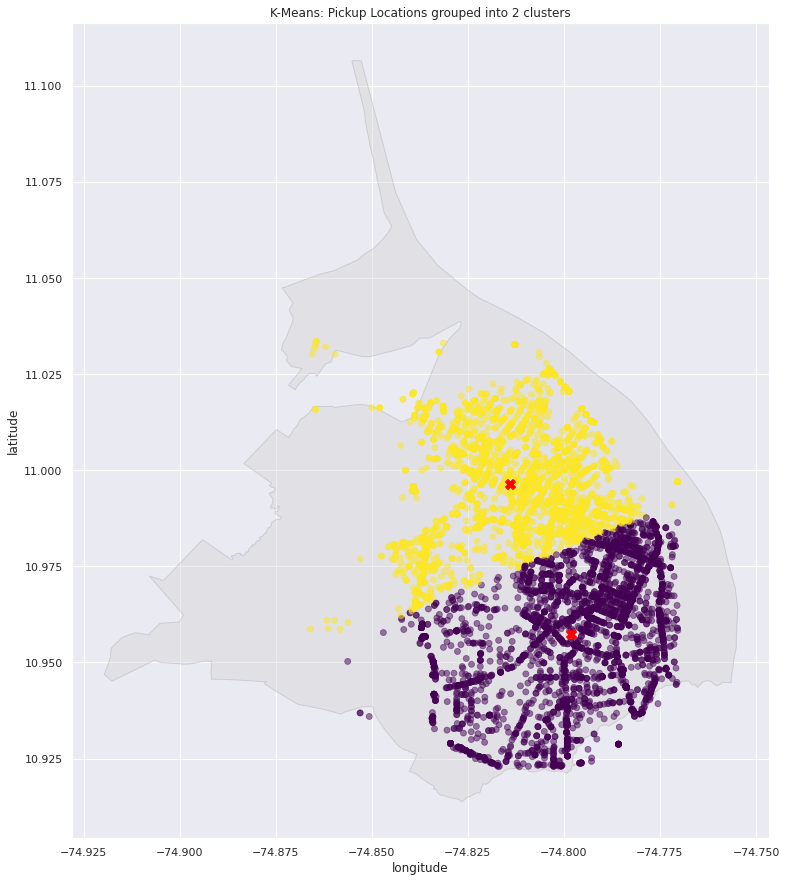

array([0, 2, 2, ..., 0, 1, 1], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


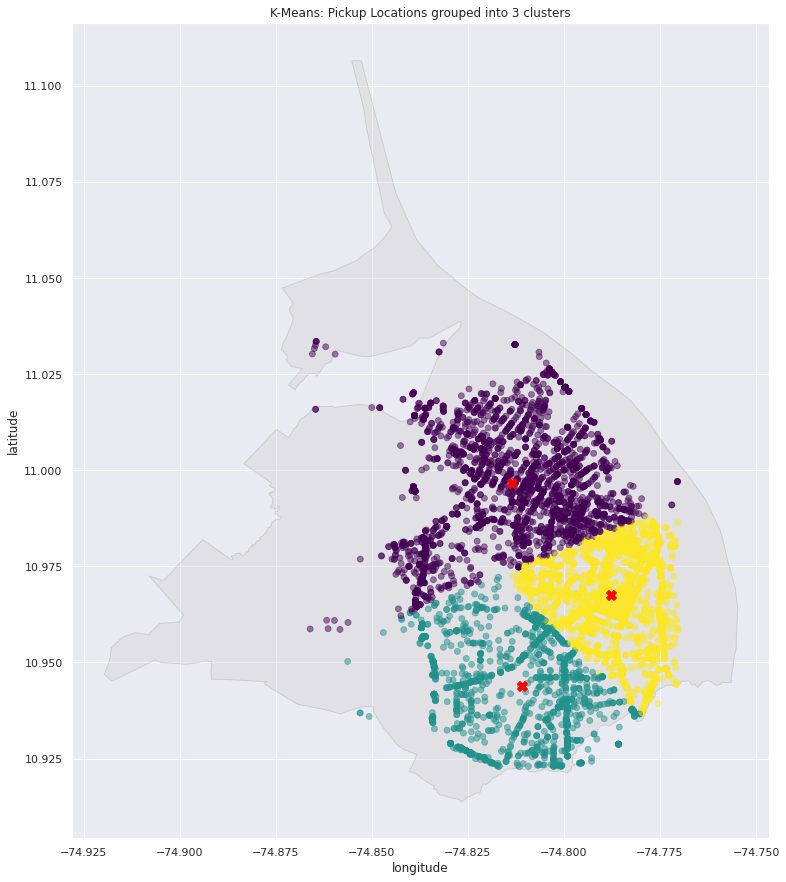

array([3, 1, 1, ..., 0, 2, 2], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


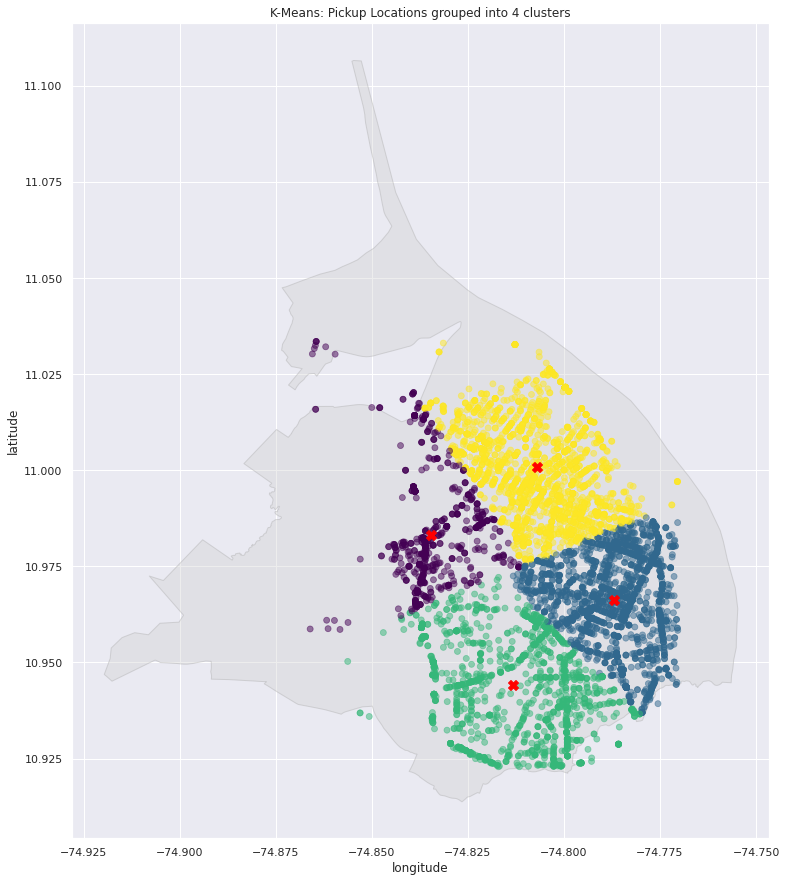

array([4, 2, 2, ..., 0, 3, 3], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


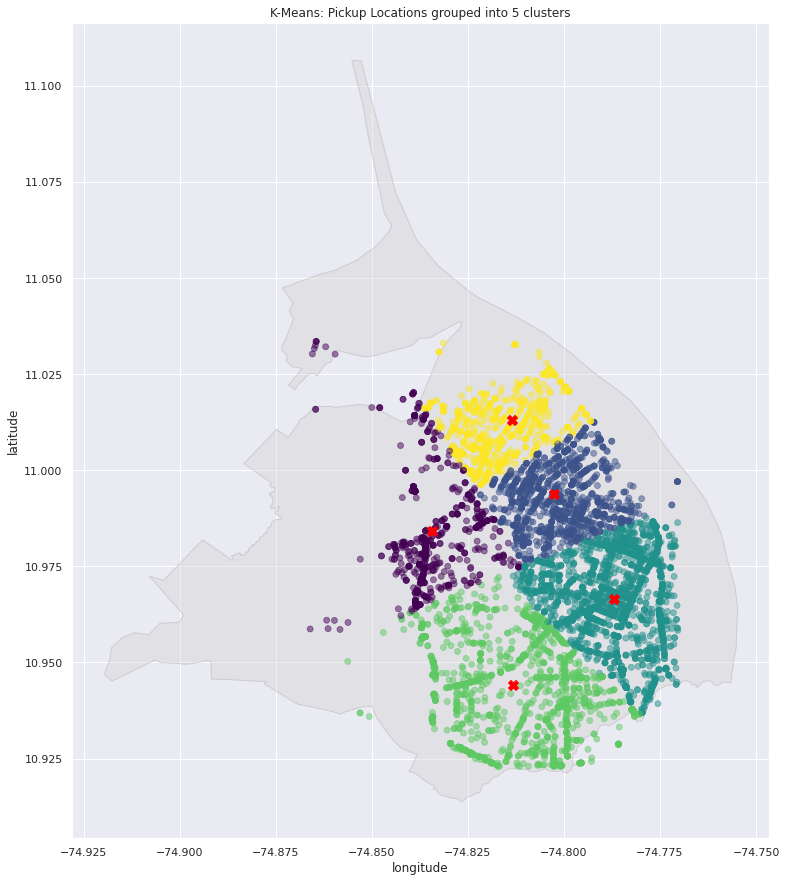

array([4, 3, 3, ..., 2, 1, 1], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


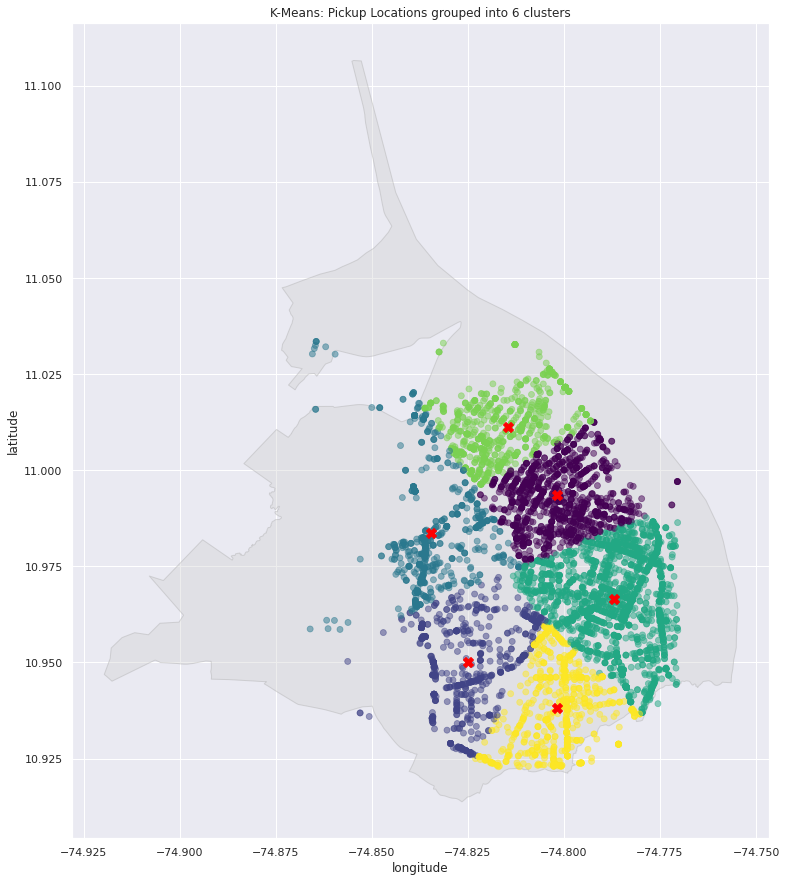

array([3, 0, 0, ..., 4, 5, 5], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


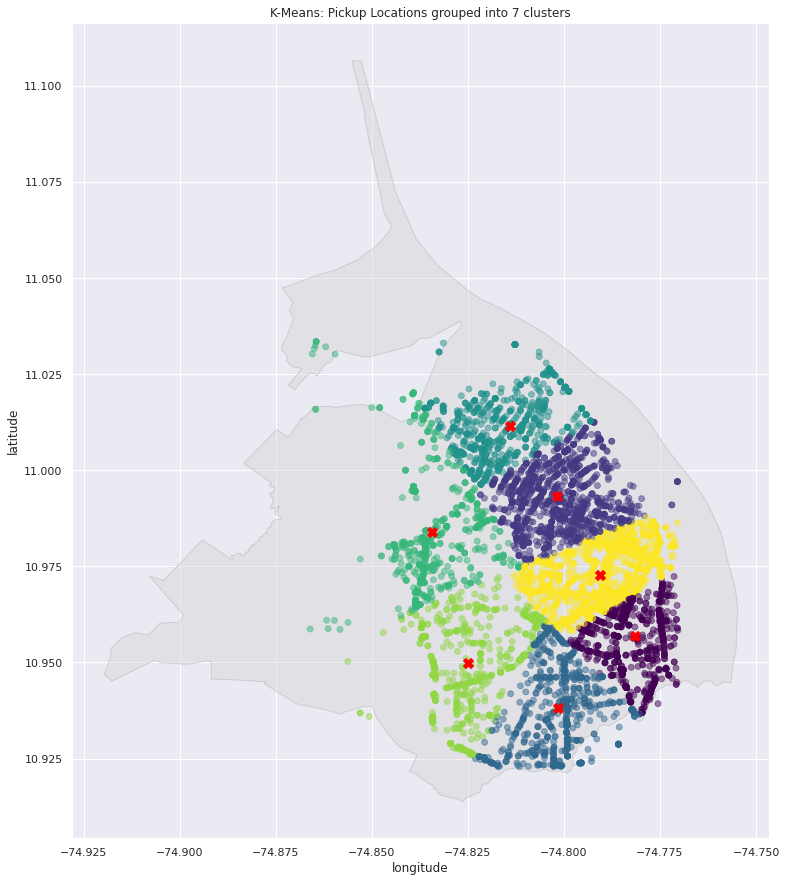

array([7, 3, 3, ..., 2, 6, 6], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


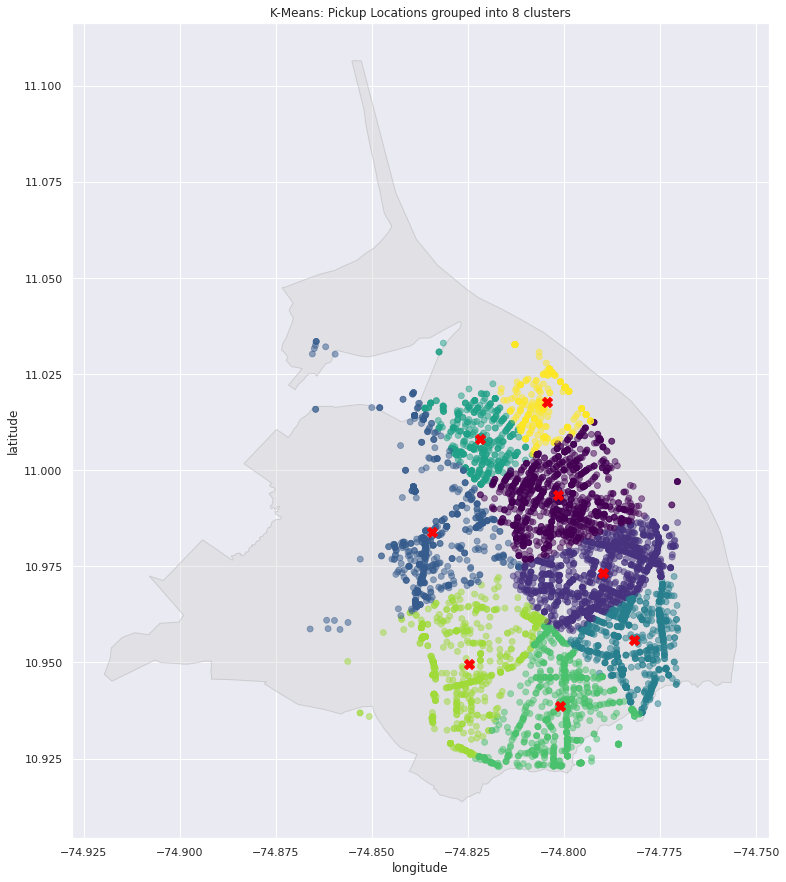

array([7, 5, 5, ..., 0, 1, 1], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


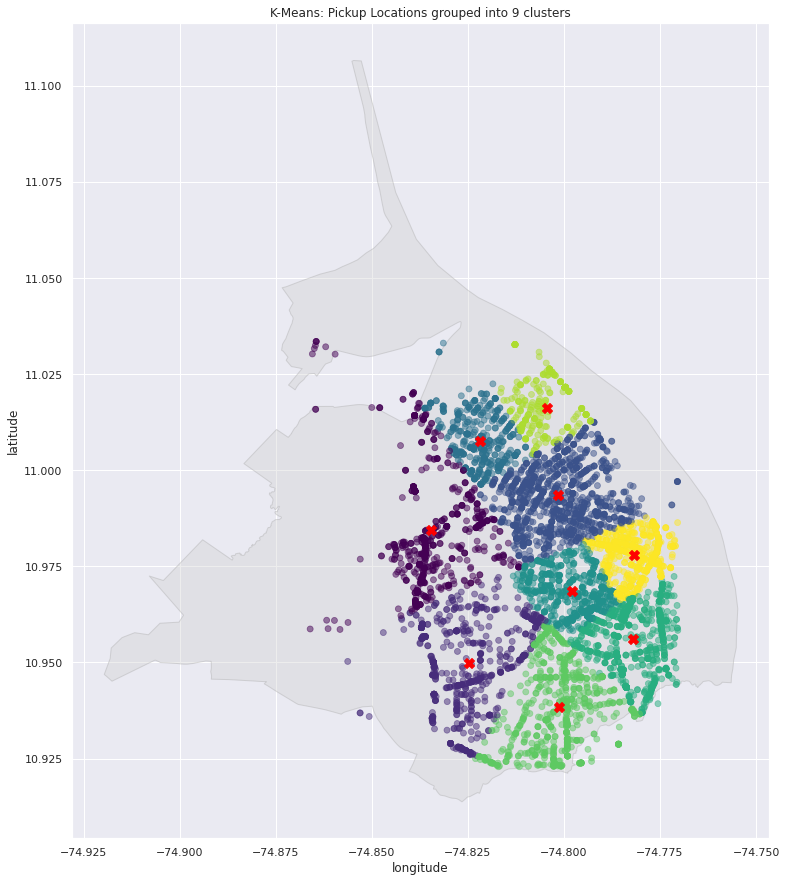

array([8, 1, 1, ..., 0, 6, 6], dtype=int32)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


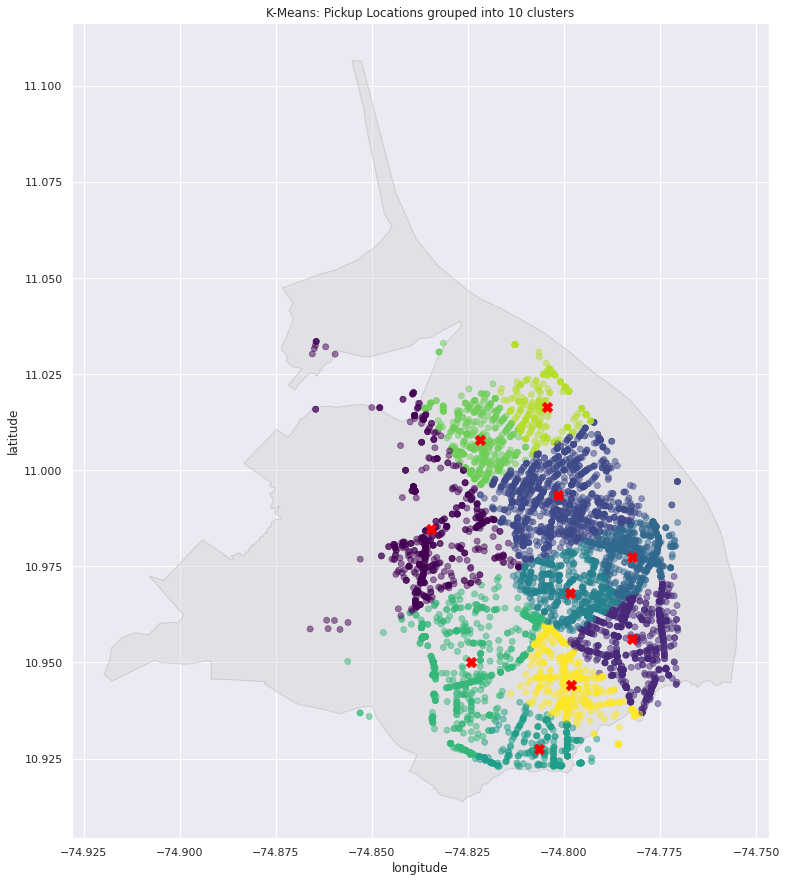

In [ ]:
ssd = []
for i in range(2, 11):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i, random_state=5)
    km.fit_predict(df_pickup_filtered)
    #y_kmeans = km.fit_predict(df_pickup_filtered)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    df_pickup_filtered['cluster'] = km.labels_
    
    # Plot lat/long and clusters on map
    plot_geolocation_by_cluster(df_pickup_filtered, cluster='cluster', 
                                title= f'K-Means: Pickup Locations grouped into {i} clusters',
                                centers=centers,filename=f'./graphics/pickup_kmeans_{i}_clusters.png')

**Elbow Method**

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum of Squared Distances')

Text(0.5, 1.0, 'Elbow Method to Find Optimal Value of k')

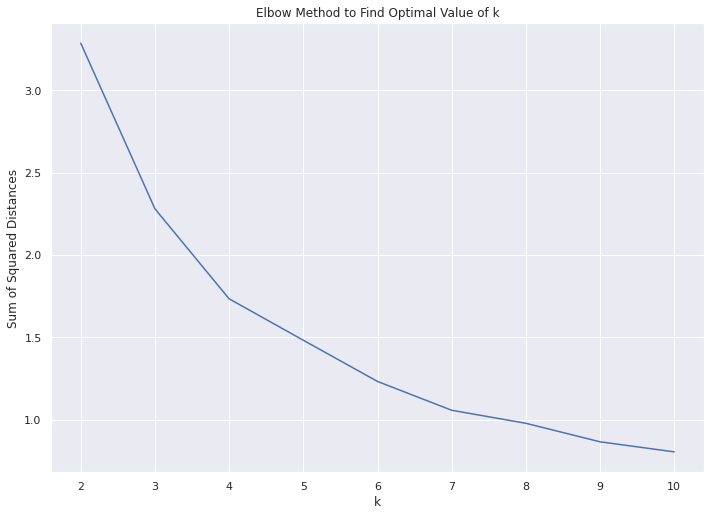

In [ ]:
#sometimes the elbow method shows different graph due to randomness of minibatch kmeans
plt.plot(range(2,11), ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method to Find Optimal Value of k')

**Best way of clustering is using 5 clusters**

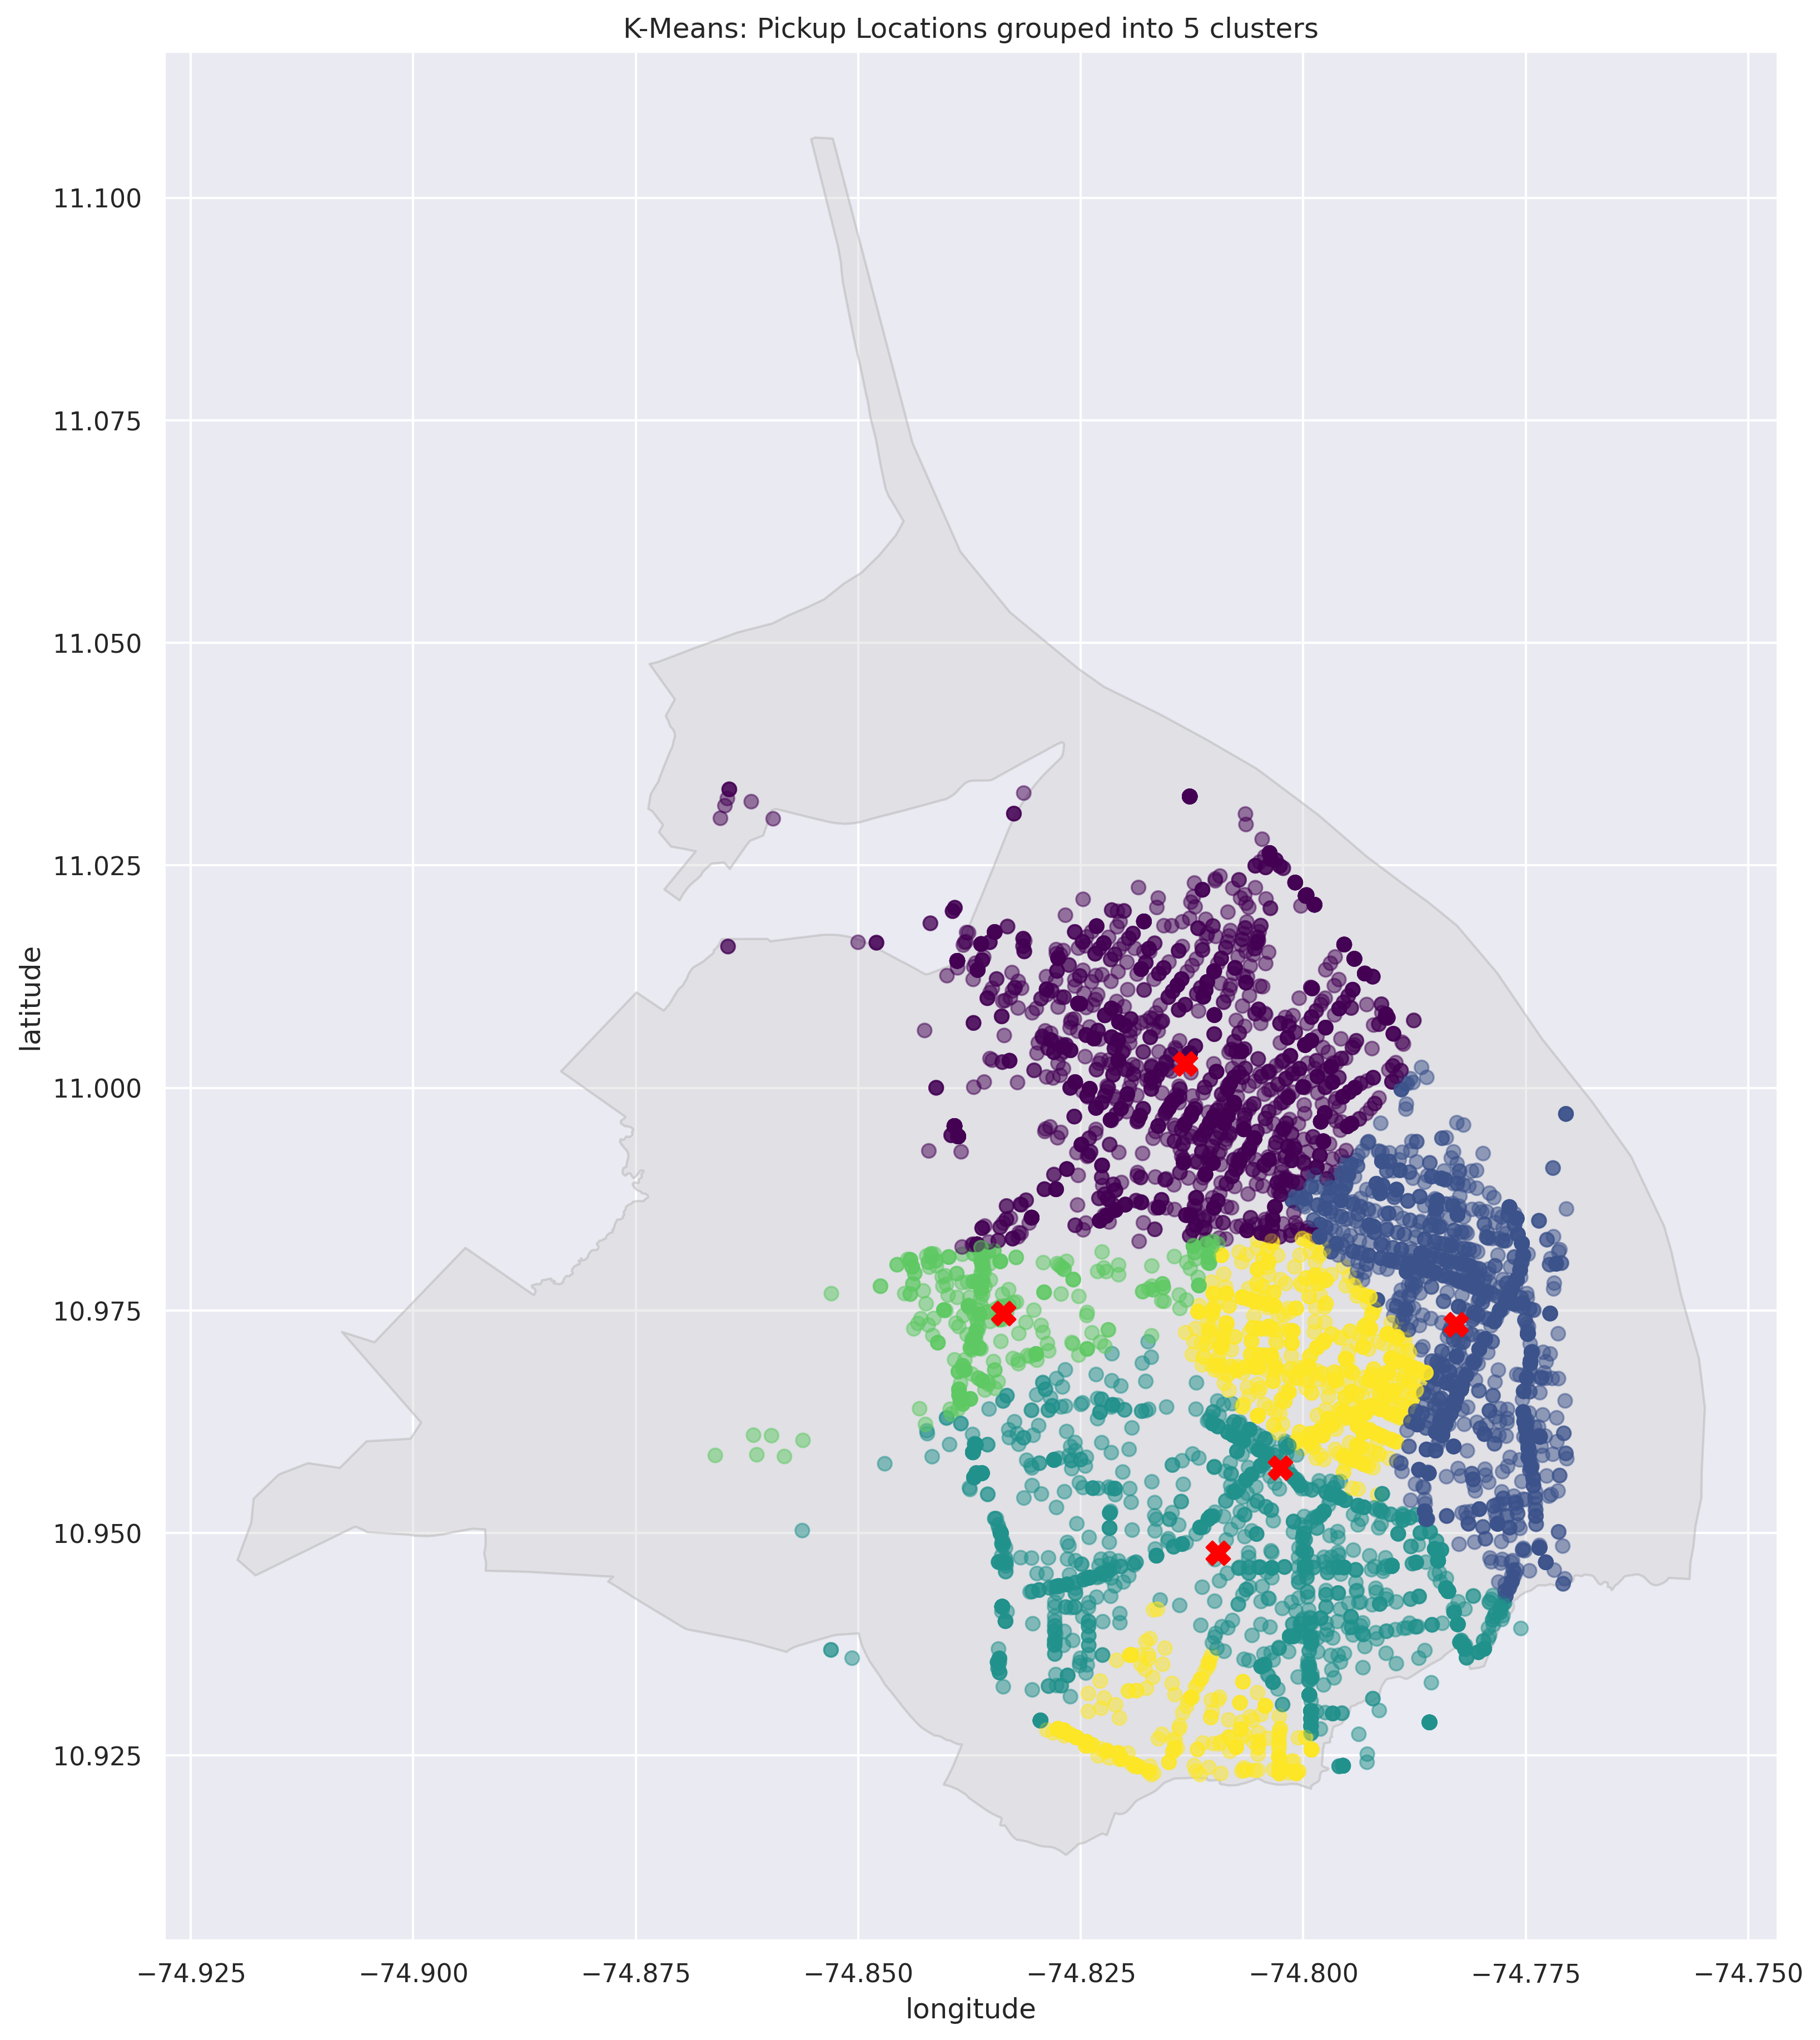

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path
gifPath = Path("./graphics/pickup_kmeans_5_clusters.png")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width = 800, height = 600)

**Combine plots into .gif**

In [ ]:
def png_to_gif(path_to_images, save_file_path, duration=1000):
    frames = []
    images = glob.glob(f'{path_to_images}')
    
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
    
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)

**Saving the gif**

In [ ]:
png_to_gif(path_to_images='./graphics/*.png', 
           save_file_path='./graphics/pickup_kmeans_clusters.gif',
           duration=500)

**Showing the gif**

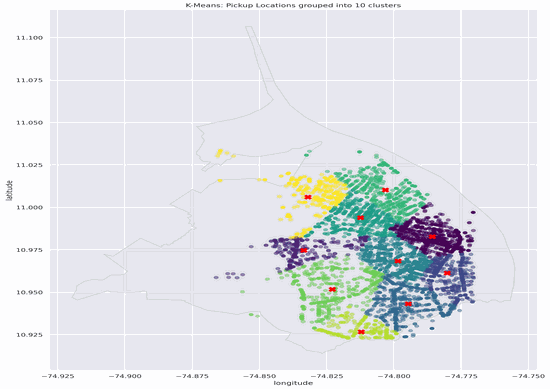

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path
gifPath = Path("./graphics/pickup_kmeans_clusters.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png', width = 800, height = 600)

**Precision of the model**

In [ ]:
print('Silhouette coefficient: %0.3f' % metrics.silhouette_score(df_pickup_filtered,y_kmeans))

Silhouette coefficient: 0.987


**Conclusions**

We can conclude that the kmeans model fits very well with data and the requirements because the centroids were the answer to the task, also we can appreciate a really impressive precision metric using silhouette coefficient.